# 構造時系列モデルベースの異常検知
* トレンド＋周期性をもつ時系列データをモデル化するための古典的な手法である構造時系列モデルをベースとして異常検知を適用してみます。

In [1]:
import pandas as pd
import numpy as np
from cmdstanpy import CmdStanModel
import arviz as az
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import japanize_matplotlib

# シナリオ（フィクション）
* ハワイ政府はマウナロアでの長年CO2濃度を監視し、430ppmを限界値として設定しています。
* 430ppmを超えた月は罰金としてパリ協定加盟国に対して総額1億USD支払わなくてはいけません。
* 430ppmを超えそうな月に対して事前に1000万USD／月の対症療法的対策をすれば罰金を支払わなくて済みます。
* 2023年現在では限界値を超えていませんが、政府としての中期計画策定のため、今後3年間の中でいつどのくらいの確率で閾値を超えてしまうかを予測したいと考えています。
* CO2濃度が閾値を超えそうなときには対策を講じ、そうでない場合は対策を講じないというアクションをすることでかかるコストを最小化したいと考えています。

## データの読込み
* [マウナロアで継続的に測定されているCO2濃度のデータ](https://gml.noaa.gov/webdata/ccgg/trends/co2/co2_mm_mlo.csv)を読み込みます。

<Axes: xlabel='Date'>

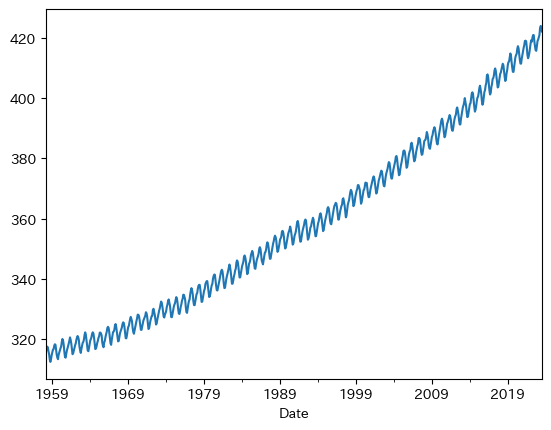

In [2]:
df = pd.read_csv("../data/co2_mm_mlo.csv")
df["Date"] = df["year"].astype(str) + "-" + df["month"].astype(str)
df["Date"] = pd.to_datetime(df["Date"])
df.set_index("Date", inplace=True)
df["average"].plot()

なんとなく、右肩上がりのトレンドと年ごとに周期性をもっていそうということが伺えます。

## 構造時系列モデル

### トレンド成分
* 経時的なトレンド（右肩上がり or 右肩下がり）をモデル化するために、水準成分$\mu_t$と傾き成分$\delta_t$を以下のように定義します。

    $\mu_t \sim Normal(\mu_{t-1} + \delta_{t-1}, \sigma_{\mu}^2)$

    $\delta_t \sim Normal(\delta_{t-1}, \sigma_{\delta}^2)$


### 季節成分
* 周期を$s$として季節成分$\gamma_t$を以下のように定義します。

    $\gamma_t \sim Normal(-\sum_{i=t-s+1}^{t-1}\gamma_i, \sigma_{\gamma}^2)$
    
### 構造時系列モデル＝トレンド成分＋季節成分
* 構造時系列モデルを以下のように定義します。

    $y_t \sim Normal(\mu_t + \delta_t, \sigma^2)$

In [78]:
model = CmdStanModel(stan_file="../models_ts/co2_structual-time-series.stan")

17:18:43 - cmdstanpy - INFO - compiling stan file /home/karinog/work/study/bayesian-time-series-anomaly-detection/models_ts/co2_structual-time-series.stan to exe file /home/karinog/work/study/bayesian-time-series-anomaly-detection/models_ts/co2_structual-time-series
17:19:03 - cmdstanpy - INFO - compiled model executable: /home/karinog/work/study/bayesian-time-series-anomaly-detection/models_ts/co2_structual-time-series


In [102]:
# 過去10年分のデータを使います。
# 10年前までのデータを学習データとします。
# 向こう3年間文の予測をしたいとします。
tr_start = -120
y_tr = df["average"].values[tr_start:]
T_tr = y_tr.size
T_te = 36
S = 12

# 閾値を設定します
thres = 430

date_tr = df.index[tr_start:]
date_te = pd.date_range("2023-08-01","2026-07-01", freq="MS")

data = dict(
    y_tr=y_tr,
    T_tr=T_tr,
    T_te=T_te,
    S=S
)

In [80]:
fit = model.sample(
        data=data,
    iter_warmup=2500, iter_sampling=1500, chains=3, show_console=False,
    # parallel_chains=6,
    adapt_delta=0.999,
    max_treedepth=20,
)

17:19:58 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

17:27:59 - cmdstanpy - INFO - CmdStan done processing.
17:27:59 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/home/karinog/work/study/bayesian-time-series-anomaly-detection/models_ts/co2_structual-time-series.stan', line 22, column 4 to column 59)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/home/karinog/work/study/bayesian-time-series-anomaly-detection/models_ts/co2_structual-time-series.stan', line 21, column 4 to column 70)
Consider re-running with show_console=True if the above output is unclear!


In [81]:
# 念の為診断
print(fit.diagnose())

Processing csv files: /tmp/tmp7ij2ue11/co2_structual-time-seriesephmnc0a/co2_structual-time-series-20230828171958_1.csv, /tmp/tmp7ij2ue11/co2_structual-time-seriesephmnc0a/co2_structual-time-series-20230828171958_2.csv, /tmp/tmp7ij2ue11/co2_structual-time-seriesephmnc0a/co2_structual-time-series-20230828171958_3.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
The E-BFMI, 0.02, is below the nominal threshold of 0.30 which suggests that HMC may have trouble exploring the target distribution.
If possible, try to reparameterize the model.

Effective sample size satisfactory.

The following parameters had split R-hat greater than 1.05:
  sigma_delta
Such high values indicate incomplete mixing and biased estimation.
You should consider regularizating your model with additional prior information or a more effective

In [82]:
fit.summary()

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
lp__,1090.950000,37.009200,123.260000,903.204000,1093.330000,1284.550000,11.09230,0.030391,1.16469
sigma_mu,0.222932,0.001960,0.043788,0.152240,0.221271,0.295885,499.17000,1.367620,1.00359
sigma_delta,0.008976,0.003333,0.007991,0.001261,0.006222,0.025489,5.74951,0.015752,1.20904
sigma_seasonal,0.046628,0.003004,0.021446,0.015584,0.044372,0.085757,50.96440,0.139632,1.02502
sigma,0.200196,0.002163,0.042553,0.126888,0.201189,0.269211,387.19700,1.060840,1.00190
...,...,...,...,...,...,...,...,...,...
delta_hat[152],0.222955,0.003050,0.090041,0.107076,0.213752,0.381620,871.71700,2.388320,1.00799
delta_hat[153],0.222805,0.003010,0.090938,0.105434,0.213342,0.380900,912.97200,2.501350,1.00799
delta_hat[154],0.222915,0.003072,0.091683,0.103861,0.213193,0.383605,890.68100,2.440280,1.00763
delta_hat[155],0.222672,0.002923,0.092425,0.103735,0.213296,0.382236,999.49700,2.738410,1.00709


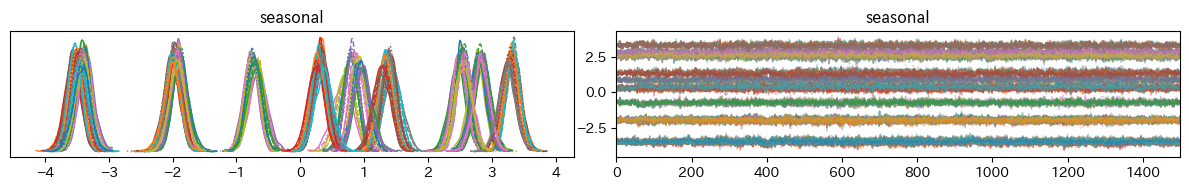

In [83]:
output = az.from_cmdstanpy(posterior=fit)
az.plot_trace(output, var_names=["seasonal"])
plt.tight_layout()

## EAP推定

In [101]:
samples = fit.stan_variables()

y_tr_hat = samples["y_tr_hat"].mean(0)
y_te_hat = samples["y_te_hat"].mean(0)
y_tr_lower, y_tr_upper = np.quantile(samples["y_tr_hat"], [0.025,0.975], axis=0)
y_te_lower, y_te_upper = np.quantile(samples["y_te_hat"], [0.025,0.975], axis=0)
seasonal_lower, seasonal_upper = np.quantile(samples["seasonal"], [0.025,0.975], axis=0)
mu_lower, mu_upper = np.quantile(samples["mu"], [0.025,0.975], axis=0)
delta_lower, delta_upper = np.quantile(samples["delta"], [0.025,0.975], axis=0)

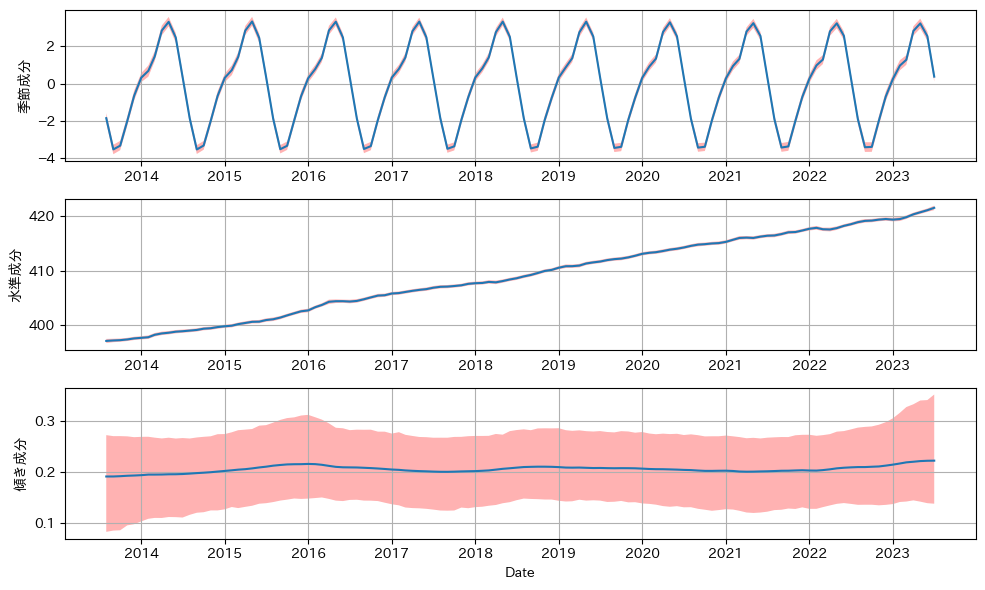

In [96]:
plt.figure(figsize=(10,6))
plt.subplot(3,1,1)
plt.plot(date_tr, samples["seasonal"].mean(0))
plt.fill_between(date_tr, y1=seasonal_lower, y2=seasonal_upper, alpha=0.3, color="r", edgecolor=None, label="95%ベイズ信頼区間")
plt.ylabel("季節成分")
plt.grid()

plt.subplot(3,1,2)
plt.plot(date_tr, samples["mu"].mean(0))
plt.fill_between(date_tr, y1=mu_lower, y2=mu_upper, alpha=0.3, color="r", edgecolor=None, label="95%ベイズ信頼区間")
plt.ylabel("水準成分")
plt.grid()

plt.subplot(3,1,3)
plt.plot(date_tr, samples["delta"].mean(0))
plt.fill_between(date_tr, y1=delta_lower, y2=delta_upper, alpha=0.3, color="r", edgecolor=None, label="95%ベイズ信頼区間")
plt.ylabel("傾き成分")
plt.xlabel("Date")
plt.grid()

plt.tight_layout()
plt.show()

In [97]:
y_hat = np.hstack((y_tr_hat, y_te_hat))
y_upper = np.hstack((y_tr_upper, y_te_upper))
y_lower = np.hstack((y_tr_lower, y_te_lower))

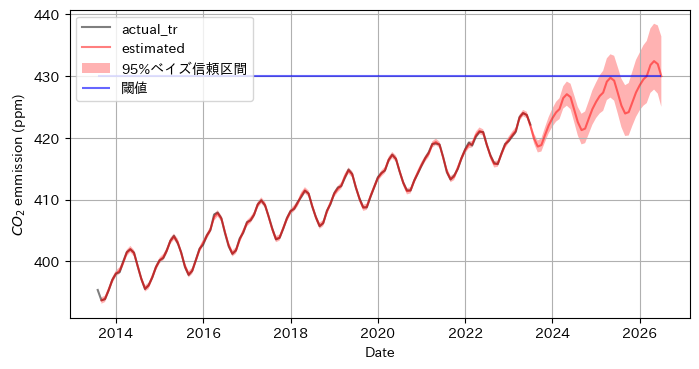

In [108]:
plt.figure(figsize=(8,4))
plt.plot(date_tr, y_tr, alpha=0.5, color="k", label="actual_tr")
# plt.plot(date_te, y_te, alpha=0.5, color="b", label="actual_te")
plt.plot(np.hstack((date_tr, date_te)), y_hat, alpha=0.5, color="r", label="estimated")
plt.fill_between(np.hstack((date_tr, date_te)), y1=y_lower, y2=y_upper, color="r", alpha=0.3, edgecolor=None, label="95%ベイズ信頼区間")
plt.hlines(y=thres, xmin=date_tr.min(), xmax=date_te.max(), color="b", label="閾値", alpha=0.6)
plt.legend()
plt.grid()
plt.xlabel("Date")
plt.ylabel("$CO_2$ emmission (ppm)")
plt.show()
# plt.plot(y_te_hat)

## 利得行列
* CO2濃度が閾値を超えた場合とそうでない場合とで対策有無により発生する利得をテーブルとして整理します。
    * CO2濃度が閾値を超えた場合
        * 対策しなかったら：1億USDのコストが発生
        * 対策したら：1000万USDのコストが発生 ← ベストなアクション
    * CO2濃度が閾値を超えなかった場合
        * 対策しなかったら：コストかからない ← ベストなアクション
        * 対策したら：1000万USDのコストが発生

In [109]:
df_cost = pd.DataFrame([[-100, -10],[0,-10]], columns=["対策なし","対策あり"], index=[f"y_t＞{thres}",f"y_t≦{thres}"])
print("単位：million USD")
df_cost

単位：million USD


,対策なし,対策あり
y_t＞430,-100,-10
y_t≦430,0,-10


In [131]:
p_mt_thres = (samples["y_te_hat"]>thres).mean(0)
df_p = pd.DataFrame(
    np.c_[p_mt_thres, 1-p_mt_thres], 
    columns=[f"p(y_t＞{thres})",f"p(y_t≦{thres})"],
    index=date_te
)
df_p

,p(y_t＞430),p(y_t≦430)
2023-08-01,0.000000,1.000000
2023-09-01,0.000000,1.000000
2023-10-01,0.000000,1.000000
2023-11-01,0.000000,1.000000
2023-12-01,0.000000,1.000000
2024-01-01,0.000000,1.000000
2024-02-01,0.000000,1.000000
2024-03-01,0.000000,1.000000
2024-04-01,0.001778,0.998222
2024-05-01,0.005333,0.994667


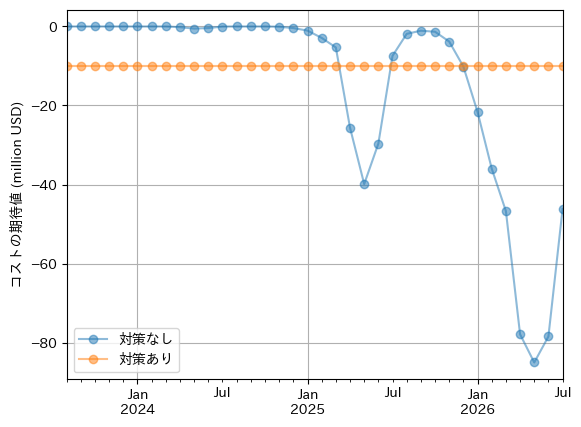

In [144]:
df_cost_monthly = df_cost.T.dot(df_p.values.T).T
df_cost_monthly.index = date_te
df_cost_monthly.plot(ylabel="コストの期待値 (million USD)", marker="o", alpha=0.5, grid=True);

In [146]:
# コストの期待値が大きくなるアクションを選択した場合のコスト期待値総額
cost_best  = df_cost_monthly.max(1).sum()
cost_best

-136.35555555555555

In [147]:
# 予測に頼らず毎月なにも対策しない場合と、毎月必ず対策した場合のコスト期待値総額
cost_w_no_action_every_month, cost_w_action_every_month = df_cost_monthly.sum(0)
cost_w_no_action_every_month, cost_w_action_every_month 

(-523.6, -360.0)

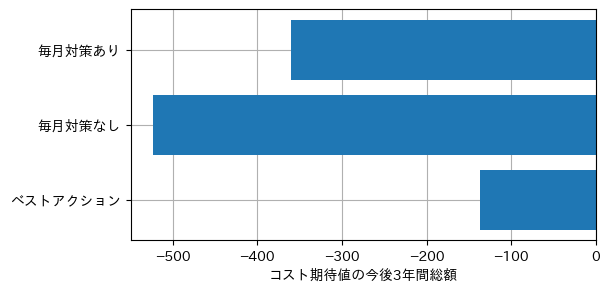

In [154]:
plt.figure(figsize=(6,3))
plt.barh(
    ["ベストアクション","毎月対策なし","毎月対策あり"],
    [cost_best, cost_w_no_action_every_month, cost_w_action_every_month],
    zorder=2
)
plt.xlabel("コスト期待値の今後3年間総額")
plt.grid(zorder=1)
plt.show()

予測を使わない場合に比べて、予測を使うことによってコスト期待値の総額が大幅に削減することができました。

EOL